In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
from pathlib import Path
import itertools
import pickle
import seaborn as sns
import jax
import jax.numpy as np
import numpy
import scipy
import seaborn as sns
from tqdm import tqdm
jax.config.update('jax_platform_name', 'cpu')
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=16'

In [3]:
from sklearn.cluster import MiniBatchKMeans
seed = 42

In [4]:
from bomtemplate.bd_transformation import fc_phases_space, fc_space, activity_space
from bomtemplate.into_states import clustering
from bomtemplate.reliability_assessment import fingerprinting, predictive_power
from bomtemplate import utility
from bomtemplate import bd_preprocessing

In [5]:
cwd = os.getcwd()
head = Path(cwd).parents[2]
path_data = os.path.join(head, 'saved_data/')

In [6]:
path_figures = os.path.join(head, 'figures/emp/pepr_April2024/v1s')


In [7]:
getdata = bd_preprocessing.Get_1000Brains_Data(path_data)
output_dict = getdata.get_data(bins=False)
output_dict.keys()

dict_keys(['data_3d', 'ages', 'TR', 'transient'])

In [8]:
transient = output_dict['transient']
data_3d = output_dict['data_3d'][:,transient:]
n_participants, n_samples, n_nodes = data_3d.shape

In [9]:
lowcut = 0.01
highcut = 0.08
data_3d_filtered = numpy.zeros_like(data_3d)
for p in range(n_participants):
    data_3d_filtered[p] = bd_preprocessing.butter_bandpass_filter(data_3d[p], axis=0, lowcut=lowcut, highcut=highcut, fs=1, order=1)

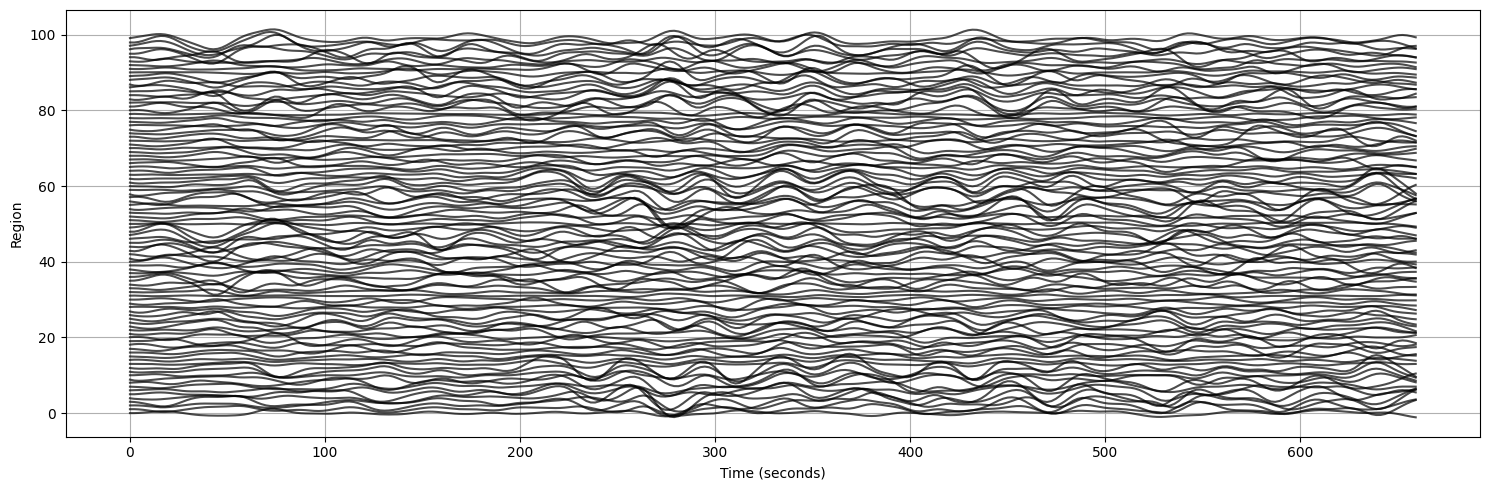

In [10]:
TR = output_dict['TR']
bd_preprocessing.plot_filtered_ts(data_3d_filtered[9], TR=TR)

# v1s methods

## step 1: transform the data

In [11]:
load_v1s = False
if not load_v1s:
    est_v1s = fc_phases_space.V1s()
    v1s = est_v1s.fit_transform(data_3d_filtered) #slow and memory expensive
else:
    v1s = np.load(os.path.join(head, 'intermediate_files/v1s.npy'))

### all flipping methods

In [12]:
assert tuple((n_participants, n_samples, n_nodes)) == v1s.shape

In [13]:
options = ['meanK', 'meanO', 'anchor', 'markov']
v1s_all = np.zeros((len(options)+1, n_participants, n_samples, n_nodes))
v1s_all = v1s_all.at[0].set(v1s)
for i, option in enumerate(options):
    # print(i)
    v = est_v1s.flip_v1s(option=option)
    v1s_all = v1s_all.at[i+1].set(v)
options = ['noflip']+options

In [18]:
# np.save(os.path.join(head, 'intermediate_files/v1s_markov.npy'), v1s_all[-1])

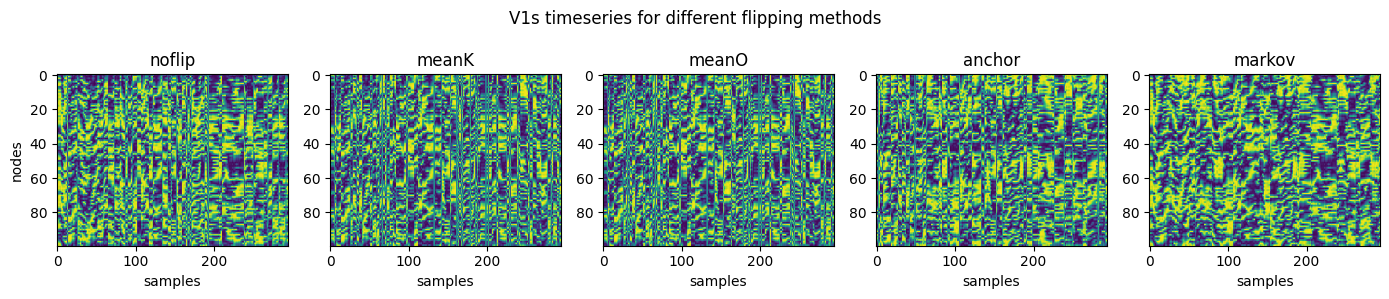

In [14]:
figure(figsize=(14,3))
for i in range(len(options)):
    subplot(1,len(options),i+1)
    title(f'{options[i]}')
    imshow(v1s_all[i][0].T, aspect='auto')
    xlabel('samples')
    if i == 0:
        ylabel('nodes')
suptitle('V1s timeseries for different flipping methods')
tight_layout()
# savefig(os.path.join(path_figures, 'v1s_carpet_plots.png'), dpi=250, bbox_inches='tight')


## step2: cluster into recurrent objects

In [ ]:
v1s_all.shape

(5, 648, 294, 100)

In [ ]:
n_states = 5
part = getdata.split_test_retest(removed_transient=1)
part

133

In [ ]:
telab_grouped_all, retelab_grouped_all = [], []
for i in tqdm(range(len(options))):
    xtest = v1s_all[i,:,:part]
    xretest = v1s_all[i,:,-part:]
    k = clustering.Cluster()
    kmeans = MiniBatchKMeans(n_clusters=n_states, n_init='auto', random_state=seed)
    xtest = xtest.reshape(-1, n_nodes)
    xretest = xretest.reshape(-1, n_nodes)
    k.fit(xtest, kmeans)
    X  = k.predict(xtest).reshape(n_participants,-1)
    y  = k.predict(xretest).reshape(n_participants,-1)
    telab_grouped_all.append(X)
    retelab_grouped_all.append(y)
telab_grouped_all = np.asarray(telab_grouped_all)
retelab_grouped_all = np.asarray(retelab_grouped_all)
telab_grouped_all.shape, retelab_grouped_all.shape

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


((5, 648, 133), (5, 648, 133))

#### step 3: reliability assessment

In [ ]:
def intrasim_intersim_plot(intersim, intrasim,
                           permuted_statistics, observed_statistic, p_value,
                           stitle=None, save=False):
    figure(figsize=(7, 3.5))
    suptitle(stitle)
    subplot(121)
    hist(intersim, 20, label='Intersubject sim', alpha=0.5)
    hist(intrasim, 20, label='Intrasubject sim', alpha=0.5)
    xlabel('cos-sim test-retest \n occurence ratio'); ylabel('# subjects'); grid(1);
    title(f'for {n_states} states: \n inter={intersim.mean():0.2f}; intra={intrasim.mean():0.2f}')
    legend()
    subplot(122)
    hist(permuted_statistics, bins=30, density=True, alpha=0.7, color='grey', label='Permuted Test Statistics')
    axvline(x=observed_statistic, color='red', linestyle='--', label='Observed Test Statistic')
    annotate(rf'p-value={p_value}',
                    xy=(0.6, 0.5), xycoords='axes fraction', fontsize=11)
    xlabel('Test Statistic')
    ylabel('Density')
    title('Permuted vs Observed \n Test Statistics')
    legend()
    tight_layout()
    if save == True:
        savefig(os.path.join(path_figures, f'fp_V1s_{stitle}.png'), dpi=250, bbox_inches='tight')
        show()
    else:
        show()

In [ ]:
X = telab_grouped_all[-1]
y = retelab_grouped_all[-1]
fp = fingerprinting.Fingerprinting()
fp.fit(X, y)
Xor, yor = fp.transform(X, y)
permst, obsst, pv = fp.score_intrasim_vs_intrasim(num_permutations=10000)

100%|██████████| 10000/10000 [00:06<00:00, 1522.46it/s]


#### continue

100%|██████████| 10000/10000 [00:06<00:00, 1641.79it/s]


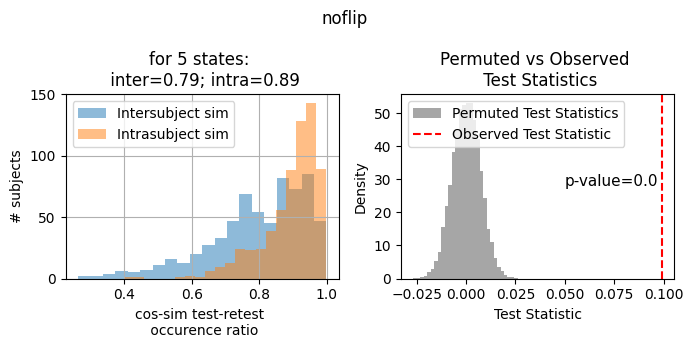

100%|██████████| 10000/10000 [00:05<00:00, 1752.59it/s]


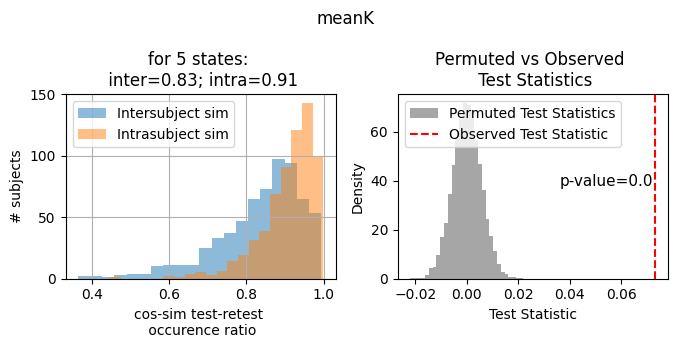

100%|██████████| 10000/10000 [00:06<00:00, 1649.66it/s]


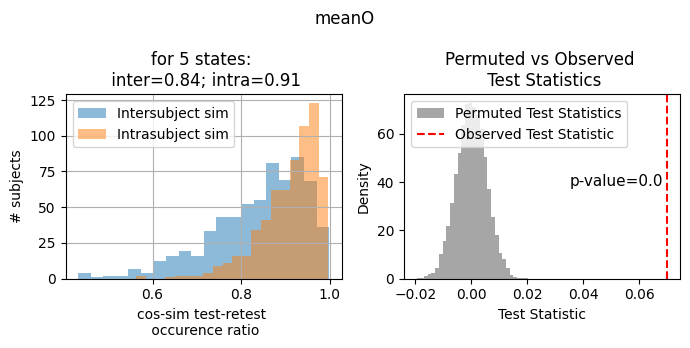

100%|██████████| 10000/10000 [00:05<00:00, 1698.53it/s]


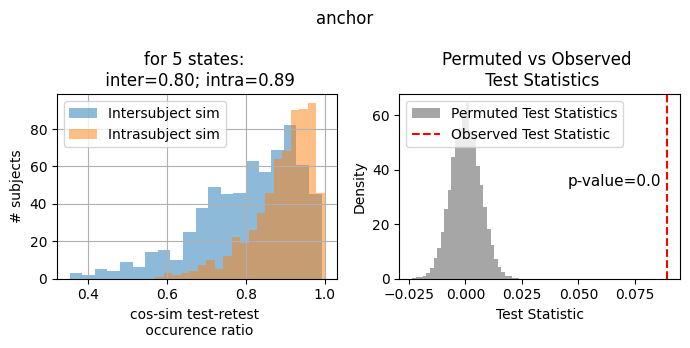

100%|██████████| 10000/10000 [00:05<00:00, 1670.81it/s]


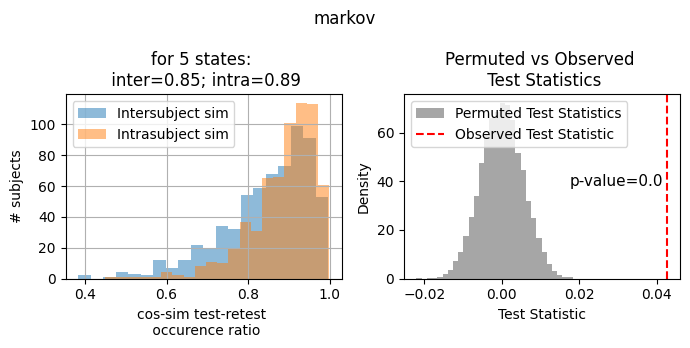

In [ ]:
for i in range(len(options)):
    X = telab_grouped_all[i]
    y = retelab_grouped_all[i]
    fp = fingerprinting.Fingerprinting()
    fp.fit(X, y)
    Xor, yor = fp.transform(X, y)
    permst, obsst, pv = fp.score_intrasim_vs_intrasim(num_permutations=10000)
    intrasim_intersim_plot(fp.intersim, fp.intrasim,
                           permst, obsst, pv, options[i], save=False)


#### step 4: predictive power

In [ ]:
train_idx, test_idx = getdata.split_train_test()
ages = output_dict["ages"]

In [ ]:
tror_grouped_all, teor_grouped_all = [], []
for i in range(len(options)):
    k = clustering.Cluster()
    kmeans = MiniBatchKMeans(n_clusters=n_states, n_init=1, init='k-means++', random_state=seed)
    xtrain = v1s_all[i,train_idx].copy()
    xtest = v1s_all[i,test_idx].copy()
    xtrain = xtrain.reshape(-1, n_nodes)
    xtest = xtest.reshape(-1, n_nodes)
    k.fit(xtrain, kmeans)
    trlab_grouped  = k.predict(xtrain).reshape(train_idx.size,-1); 
    telab_grouped  = k.predict(xtest).reshape(test_idx.size,-1); 
    f = fingerprinting.Fingerprinting()
    f.fit(trlab_grouped, telab_grouped);
    tror, teor = f.transform(trlab_grouped, telab_grouped)
    tror_grouped_all.append(tror); teor_grouped_all.append(teor)

In [ ]:
tror_grouped_all = np.asarray(tror_grouped_all)
teor_grouped_all = np.asarray(teor_grouped_all)

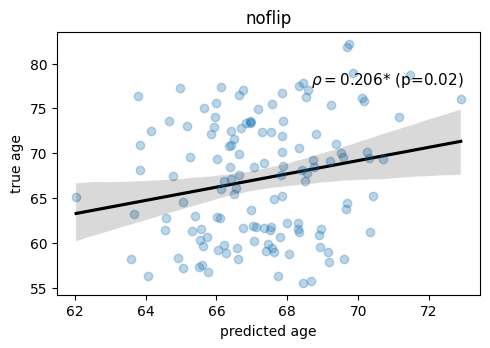

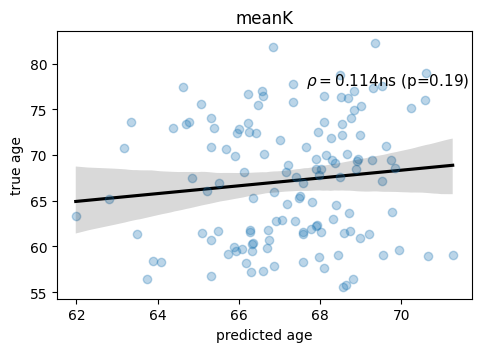

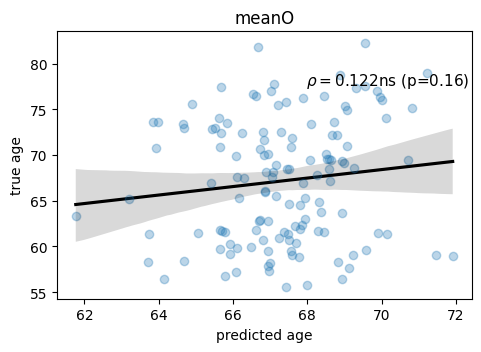

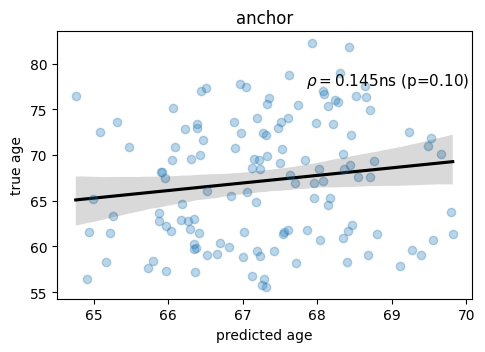

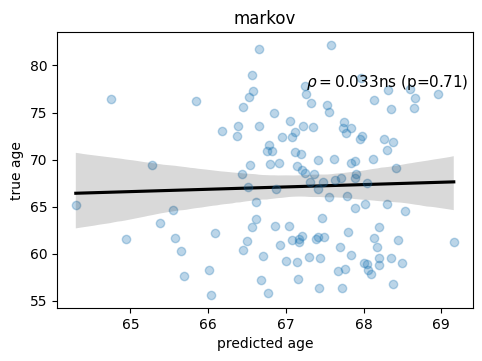

In [ ]:
for i in range(len(options)):
        figure(figsize=(5,16))  
        pp = predictive_power.Predict()
        y = ages[train_idx]
        tror = tror_grouped_all[i]
        teor = teor_grouped_all[i]
        pp.fit(tror, y)
        predictors, r_values, p_values = pp.predict(teor, ages[test_idx])
        # print(r_values, p_values)
        subplot(len(options), 1, i+1)
        y = predictors
        sns.regplot(x=y, y=ages[test_idx],
        line_kws=dict(color="k",zorder=0), ci=95, scatter_kws={"alpha": 0.3})
        slope,_,r_value,p_value,_ = scipy.stats.linregress(x=y, y=ages[test_idx])
        annotate(rf'$\rho={r_value.round(3)}${utility.convert_pvalue_to_asterisks(p_value)} (p={p_value:0.02f})',
        xy=(0.6, 0.8), xycoords='axes fraction', fontsize=11)
        ylabel('true age'), xlabel('predicted age')
        title(options[i])
        tight_layout()
        savefig(os.path.join(path_figures, f'pp_V1s_{options[i]}.png'), dpi=250, bbox_inches='tight')
        show()

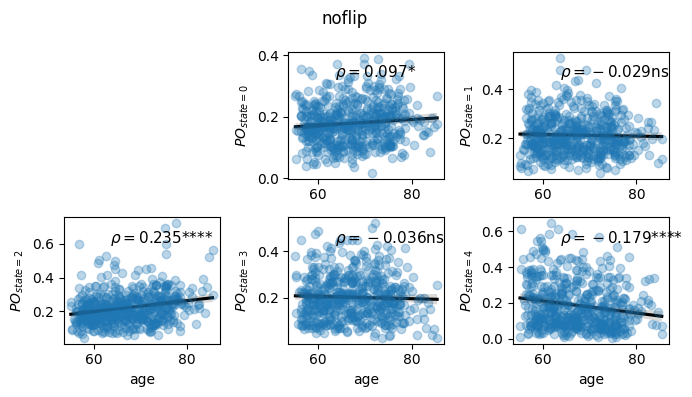

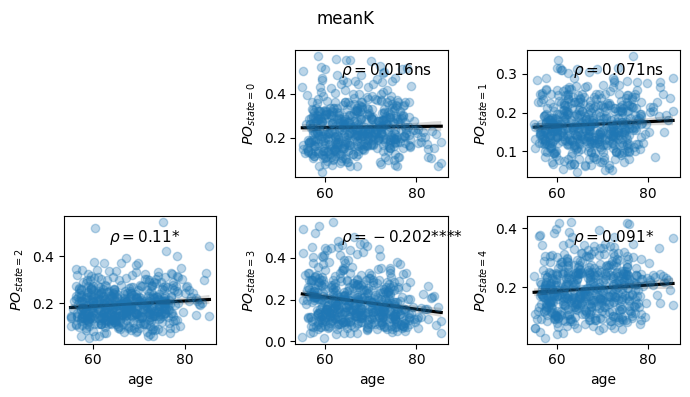

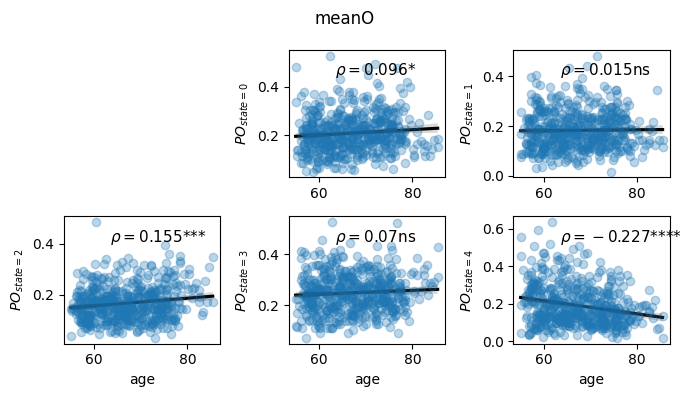

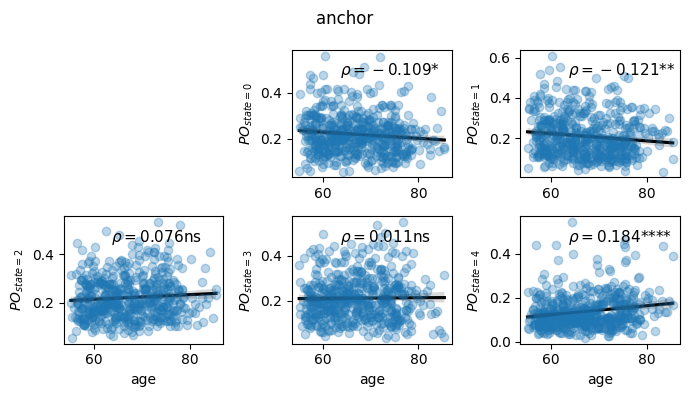

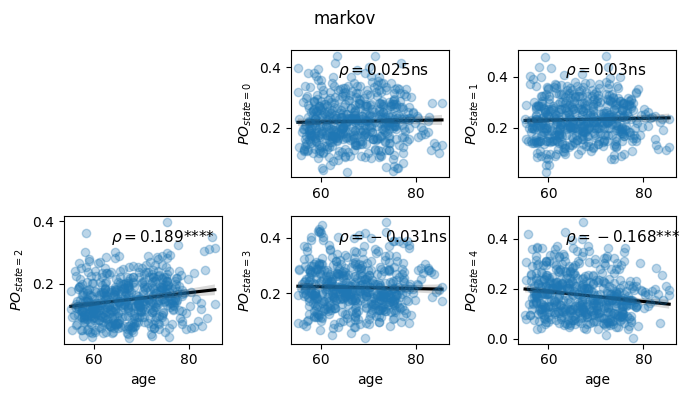

In [ ]:
b =  ages[train_idx]
for o in range(len(options)):
        figure(figsize=(7,4))
        suptitle(options[o])
        for i in range(n_states):
                y = tror_grouped_all[o][:,i]
                subplot(2,3,i+2)
                sns.regplot(x=b, y=y,
                                line_kws=dict(color="k",zorder=0), ci=95, scatter_kws={"alpha": 0.3})
                slope,_,r_value,p_value,_ = scipy.stats.linregress(x=b, y=y)
                annotate(rf'$\rho={r_value.round(3)}${utility.convert_pvalue_to_asterisks(p_value)}',
                        xy=(0.3, 0.8), xycoords='axes fraction', fontsize=11)
                ylabel(f'$PO_{{state={i}}}$')
                if i>1:
                        xlabel('age')
        tight_layout()
        savefig(os.path.join(path_figures, f'pp_perstate_V1s_{options[o]}.png'), dpi=250, bbox_inches='tight')
        show()

In [ ]:
tror_grouped_all[i].max().round(1)

Array(0.5, dtype=float32)

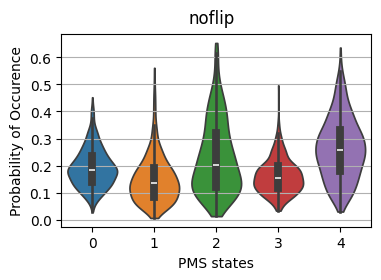

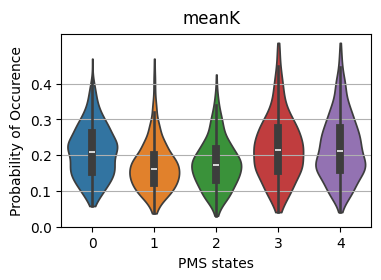

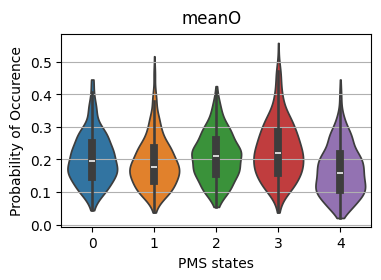

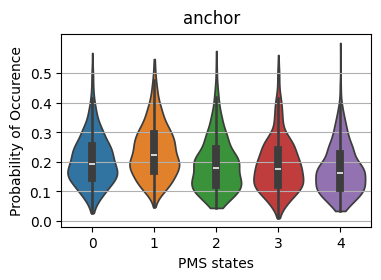

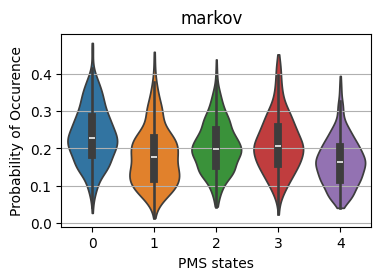

In [ ]:
for i in range(len(options)):
    figure(figsize=(4,2.5))
    suptitle(options[i])
    sns.violinplot(tror_grouped_all[i], cut=0, inner='box')
    xlabel('PMS states')
    ylabel('Probability of Occurence')
    yticks(np.r_[0:tror_grouped_all[i].max().round(1):0.1])
    grid(axis='y')
    # savefig(os.path.join(path_figures, f'PO_V1s_{options[i]}.png'), dpi=250, bbox_inches='tight')
    show()

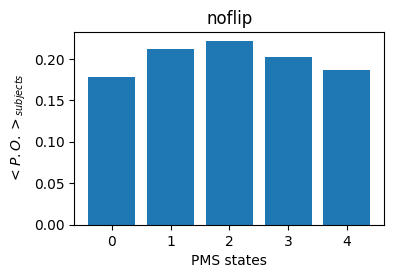

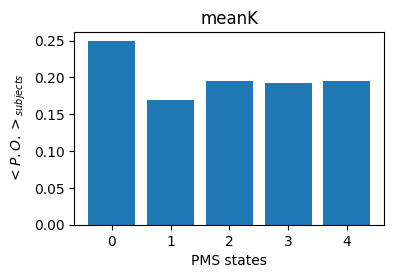

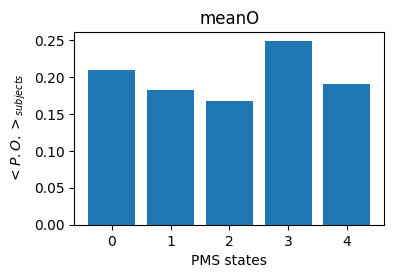

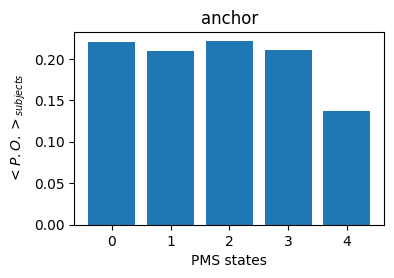

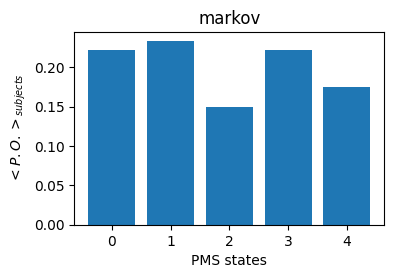

In [ ]:
for i in range(len(options)):
    figure(figsize=(4,2.5))
    title(options[i])
    bar(np.r_[0:n_states], tror_grouped_all[i].mean(0))
    xlabel('PMS states')
    ylabel(r'$<P.O.>_{subjects}$')
# savefig(os.path.join(path_figures, 'PO_mean_Zudah.png'), dpi=250, bbox_inches='tight')